In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# veritable buffet for marine microbes

In [2]:
auth = earthaccess.login()

In [4]:
tspan = ("2025-01-07", "2025-01-30")
bbox = (-131.9569, 29.4430, -100.8539, 37.9144) # west, south, east, north


In [8]:
# results_land = earthaccess.search_data(
#     short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
#     temporal=tspan,
#     bounding_box=bbox
# )
# len(results_land)

# results_oean = earthaccess.search_data(
#     short_name="PACE_SPEXONE_L2_AER_RTAPOCEAN",
#     temporal=tspan,
#     bounding_box=bbox
# )
# len(results_oean)

results_L3 = earthaccess.search_data(
    short_name="PACE_SPEXONE_L3M_AER_RTAP",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*0p1deg*",  # Daily only for MOANA | Resolution: 0p1deg or 4 (for 4km)

)
len(results_L3)


12

In [10]:
# paths_land = earthaccess.open(results_land)
# paths_ocean = earthaccess.open(results_oean)
path_spex=earthaccess.open(results_L3)

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

In [12]:

def preprocess(ds):
    datetime = ds.attrs["time_coverage_start"].replace("Z","")
    ds["date"] = ((), np.datetime64(datetime,"ns"))
    ds = ds.set_coords("date")
  #  ds = data_filler(ds)
    ds.drop_attrs()
    return ds




# for i in range(
    
# datatree = xr.open_datatree(paths_ocean[0])
# dataset = xr.merge(datatree.to_dict().values())


# # data = xr.open_mfdataset(paths_land,concat_dim='time',combine='nested')
# # dataset = xr.merge(data.to_dict().values())
# xr.open_mfdataset(paths,
#     combine="nested",
#     concat_dim="date"
# )


In [14]:
dataset_spex = xr.open_mfdataset(path_spex, combine="nested",preprocess=preprocess, concat_dim="date")
ds_subset = dataset_spex.sel(
    lon=slice(bbox[0], bbox[2]),
    lat=slice(bbox[3], bbox[1])  # note: lat is usually north→south, so reverse order
)

ssa_data=ds_subset["ssa"].mean('date').sel(wavelength='550')

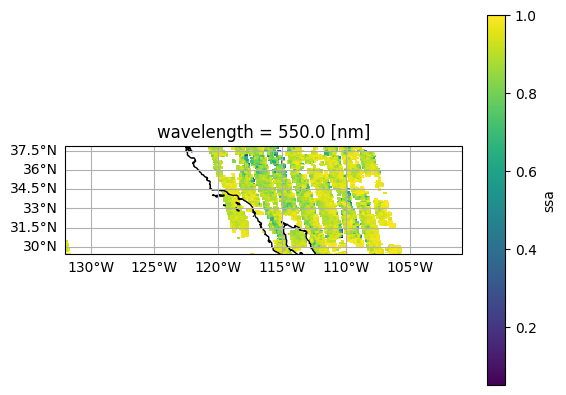

In [34]:

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = ssa_data.plot( cmap="viridis",  ax=ax
)

In [ ]:
# Download files to a local directory
files = earthaccess.download(results, download_dir)
print("Downloaded files to:", download_dir)

# Lists to store aggregated data
all_lons = []
all_lats = []
all_aots = []

print("\n--- Aggregating data from all files ---")
for file_path in files:
    print(f"Processing: {os.path.basename(file_path)}")
    try:
        # Open data groups with xarray
        with xr.open_dataset(file_path, group='geophysical_data', decode_timedelta=True) as geophys_ds, \
             xr.open_dataset(file_path, group='geolocation_data', decode_timedelta=True) as geoloc_ds, \
             xr.open_dataset(file_path, group='diagnostic_data', decode_timedelta=True) as diag_ds:

            # Check for required variables
            if 'aot' not in geophys_ds or 'latitude' not in geoloc_ds or 'longitude' not in geoloc_ds or 'chi2' not in diag_ds:
                print(f"--> Skipping: Missing required variables")
                continue

            # Check for wavelength3d dimension
            if 'wavelength3d' not in geophys_ds['aot'].dims:
                print(f"--> Skipping: No wavelength3d dimension in aot")
                continue

            # Extract data for AOT at 550 nm (wavelength3d=7)
            aot = geophys_ds['aot'].isel(wavelength3d=7).values
            lat = geoloc_ds['latitude'].values
            lon = geoloc_ds['longitude'].values
            chi2 = diag_ds['chi2'].values

            # Ensure arrays have compatible shapes
            min_rows = min(aot.shape[0], chi2.shape[0], lat.shape[0], lon.shape[0])
            if min_rows == 0:
                print(f"--> Skipping: No valid data points")
                continue

            # Trim arrays to the same size
            aot = aot[:min_rows, :]
            chi2 = chi2[:min_rows, :]
            lat = lat[:min_rows, :]
            lon = lon[:min_rows, :]

            # Filter data: AOT between 0 and 5, chi2 <= 5, and valid numbers
            mask = (aot >= 0) & (aot <= 5) & (chi2 <= 5) & np.isfinite(aot)
            aot_valid = aot[mask]
            lat_valid = lat[mask]
            lon_valid = lon[mask]

            if aot_valid.size > 0:
                all_aots.extend(aot_valid)
                all_lats.extend(lat_valid)
                all_lons.extend(lon_valid)
                print(f"--> Found {aot_valid.size} valid data points")
            else:
                print(f"--> Skipping: No valid data after filtering")

    except Exception as e:
        print(f"--> Error reading file {os.path.basename(file_path)}: {e}")
        continue